# Rapid CRISPR Quantification - Training the Neural Net
The following sections will guide you step by step to train the neural net using your data

### Installing Dependencies

In [5]:
!pip install tiffcapture

from skimage import io
import numpy as np
import torch.nn as nn
import torch.optim as optim
import os
import pickle
import scipy.optimize as opt
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from scipy import ndimage
import tiffcapture as tc
import torch
import tifffile
import glob
import warnings

warnings.filterwarnings('ignore')

def infer_mask(img):
    mask = np.zeros_like(img)
    percentile = np.percentile(img, 90)
    indices = np.where(img > percentile)
    mask[indices] = 1
    return mask

def draw_PSF(PSF_size, amp, sigma, loc):
    x = np.arange(PSF_size)
    y = np.arange(PSF_size)

    x, y = np.meshgrid(x, y)
    PSF = (amp / (2 * np.pi * sigma ** 2) * np.exp(-((x+(loc[0]%1)-(PSF_size-1)/2) ** 2 / (2 * sigma ** 2)
                                                        + (y+(loc[1]%1)-(PSF_size-1)/2) ** 2 / (2 * sigma ** 2))))
    return PSF

def AugmentData(data, damaged_site_range, size_increase):
    [N, row, col] = data.shape
    PSF_size = 9
    # Arrays initialization
    augmented_data = np.zeros([N * size_increase, row, col])
    ground_truth = np.zeros([N * size_increase, row, col])
    GT_counts = np.zeros([N * size_increase, 1])

    # Building data base and saving ground truth
    for i in range(N * size_increase):
        # Infer the mask of the cell
        augmented_data[i, :, :] = data[int(i / size_increase), :, :]

        # Rotate images randomly
        rotation_rand = np.random.randint(0, 3)
        if(rotation_rand==1):
            augmented_data[i] = np.rot90(augmented_data[i], axes=(0, 1))
        if(rotation_rand==2):
            augmented_data[i] = np.rot90(augmented_data[i], axes=(1, 0))

        # Draw mask for spots addition
        mask = infer_mask(augmented_data[i, :, :])

        # Add random number of damage sites
        damage_site_num = np.random.randint(damaged_site_range[0], damaged_site_range[1])

        GT_counts[i] = damage_site_num
        spots_locations = []

        # Add PSF shape in random location inside the cell's mask
        for j in range(damage_site_num):
            mask_arr = np.array(np.where(mask == 1))
            rng = int((PSF_size-1)/2)
            sigma = np.random.uniform(0.75, 2.25)

            # Determine the PSF location (it has to be inside the cell and far enough from other PSFs)
            while(True):
                PSF_loc_ind = np.random.choice(np.arange(mask_arr.shape[1]))
                xy = mask_arr[:, PSF_loc_ind]+np.random.normal(0, 1, 2)
                if(xy[0]+rng+1 < row and xy[0] - rng > 0 and xy[1]+rng+1 < col and xy[1] - rng > 0):
                    good_loc_flag = True
                    for k in range(len(spots_locations)):
                        if(np.abs(xy[0]-spots_locations[k][0]) < rng and np.abs(xy[1]-spots_locations[k][1]) < rng):
                            good_loc_flag = False
                            break
                    if(good_loc_flag==True):
                        spots_locations.append(xy)
                        break
                    else:
                        continue

            amp = 3 * (sigma ** 1.5) * np.random.uniform(np.percentile(data[int(i / size_increase), int(xy[0]-rng):int(xy[0]+rng+1), int(xy[1]-rng):int(xy[1]+rng+1)], 75),
                                                np.max(data[int(i / size_increase), int(xy[0]-rng):int(xy[0]+rng+1), int(xy[1]-rng):int(xy[1]+rng+1)]))
            PSF_to_draw = draw_PSF(PSF_size, amp, sigma, xy)
            PSF_GT = draw_PSF(PSF_size, 1, sigma, xy)

            augmented_data[i, int(xy[0]-rng):int(xy[0]+rng+1), int(xy[1]-rng):int(xy[1]+rng+1)] += PSF_to_draw
            ground_truth[i, int(xy[0]-rng):int(xy[0]+rng+1), int(xy[1]-rng):int(xy[1]+rng+1)] += PSF_GT

        # Project values
        augmented_data[i, :, :] = project_percentile(augmented_data[i, :, :], 90)
        ground_truth[i, :, :] = (row * col) * project_01(ground_truth[i, :, :])

    return augmented_data, ground_truth, GT_counts

def CreateDataLoader(X, y, batch_size):
    """
        Creates data loader for X, y pairs
        :param X: Tensor [# of observations, numOfBins] for the observations
        :param y: Tensor [# of observations] for the predictions
        :param batch_size: Int for batch size
        :return: data loader for training/ testing routines
    """
    data_loader = torch.utils.data.DataLoader(TensorDataset(X, y), batch_size=batch_size)
    return data_loader

def gauss2d_assymetric(xy, offset, amp, x0, y0, sigma_x, sigma_y):
    # Fit patch to gaussian
    x, y = xy
    return offset + amp * np.exp(-(((x - x0) ** 2)/ (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))

def save_data(X, y):
    np.save('X', X)
    np.save('y', y)

def load_data():
    X = np.load('X.npy')
    y = np.load('y.npy')
    return [X, y]

def LoadTIFF(file, path):
    tiff = io.imread(os.path.join(path, file))
    data_shape = tiff[0].shape
    length = tiff.shape[0]

    data = np.zeros((length, data_shape[0], data_shape[1]))
    for i in range(length):
        data[i, :data_shape[0], :data_shape[1]] = tiff[i]

    return data

def ExportTIFF(X_test, y_test_pred, augmented_data_test, data_path):
    for i in range(X_test.shape[0]):
        fig = plt.figure()
        [spots_count, spots_coord, confidence, _] = count_molecules(X_test.data.numpy()[i, 0],
                                                                 y_test_pred.data.numpy()[i, 0], patch_length=5,
                                                                 conf_threshold=100, verbose=False)
        plt.imshow(augmented_data_test[i])
        if(spots_coord.shape[0] != 0):
            plt.scatter(spots_coord[:, 1], spots_coord[:, 0], marker='x', c='r')
        fig.savefig(os.path.join(data_path, 'input_{}.tif'.format(i)))

    for i in range(X_test.shape[0]):
        fig2 = plt.figure()
        [spots_count, spots_coord, confidence, _] = count_molecules(X_test.data.numpy()[i, 0],
                                                                 y_test_pred.data.numpy()[i, 0], patch_length=5,
                                                                 conf_threshold=100, verbose=False)
        plt.imshow(y_test_pred.data[i, 0])
        if (spots_coord.shape[0] != 0):
            coord = np.concatenate([np.zeros([1, 2]), spots_coord, np.zeros([1, 2])])
            plt.scatter(coord[:, 1], coord[:, 0], marker='x', c='r')
        fig2.savefig(os.path.join(data_path, 'net_output_{}.tif'.format(i)))

def ExportTIFF_clean(X_test, y_test_pred, augmented_data_test, data_path):
    for i in range(X_test.shape[0]):
        fig = plt.figure()
        [spots_count, spots_coord, confidence, _] = count_molecules(X_test.data.numpy()[i, 0],
                                                                 y_test_pred.data.numpy()[i, 0], patch_length=5,
                                                                 conf_threshold=100, verbose=False)
        plt.imshow(augmented_data_test[i])
        fig.savefig(os.path.join(data_path, 'input_{}.tif'.format(i)))

    for i in range(X_test.shape[0]):
        fig2 = plt.figure()
        [spots_count, spots_coord, confidence, _] = count_molecules(X_test.data.numpy()[i, 0],
                                                                 y_test_pred.data.numpy()[i, 0], patch_length=5,
                                                                 conf_threshold=100, verbose=False)
        plt.imshow(y_test_pred.data[i, 0])
        fig2.savefig(os.path.join(data_path, 'net_output_{}.tif'.format(i)))

def ShrinkImages(data, size, save_coord=False):
    [H, W] = data.shape
    from scipy import ndimage
    new_data = 30 * np.ones([size, size])
    data_filt = np.zeros_like(data)
    data_filt[np.where(data > np.median(data))] = data[np.where(data > np.median(data))]
    [x0, y0] = ndimage.measurements.center_of_mass(data_filt)
    max_ind = np.argmax(data)
    x0 = (x0 + max_ind % W) / 2
    y0 = (y0 + max_ind / W) / 2
    left = np.max([0, int(x0 - size/2)])
    right = np.min([int(x0 + size/2), W])
    down = np.max([0, int(y0 - size/2)])
    up = np.min([int(y0 + size/2), H])
    new_data[:up-down, :right-left] = data[down:up, left:right]
    if save_coord:
        return new_data, np.array([down, left])
    else:
        return new_data


import scipy.optimize as opt
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import butter,filtfilt

def gauss2d(xy, offset, amp, x0, y0, sigma):
    # Fit patch to gaussian
    x, y = xy
    return offset + amp * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def count_molecules(orig_img, img, patch_length, conf_threshold, verbose):
    mask = np.zeros_like(img)
    percentile = np.percentile(orig_img, 85)
    indices = np.where(orig_img > percentile)
    mask[indices] = 1

    emitters_cnt = 0
    emitters_coordinates = []
    intensity = []
    confidence = []
    max_row, max_col = img.shape
    xy = np.zeros([2, int(patch_length ** 2)])
    for i1 in range(patch_length):
        for j1 in range(patch_length):
            xy[:, int(i1 + patch_length * j1)] = [i1, j1]

    for i in range(len(indices[0])):
        row, col = indices[0][i], indices[1][i]

        if(img[int(row), int(col)] < 0):
            continue

        # Handle clusters in case of exceeding image shape
        up = int(row + np.floor(patch_length / 2)) + 1
        down = int(row - np.floor(patch_length / 2))
        left = int(col - np.floor(patch_length / 2))
        right = int(col + np.floor(patch_length / 2)) + 1

        # Ignore out of bound blinks
        if up > max_row or down < 0 or left < 0 or right > max_col:
            continue

        # Check if localization is in local maximum
        local_max = np.max(img[int(row - 1):int(row + 2), int(col - 1):int(col + 2)])
        if (local_max * 0.8 > img[int(row), int(col)]):
            if verbose == True:
                print("Not local max:", local_max, img[int(row), int(col)])
            continue

        # Initial guess
        x0, y0 = int(np.floor(patch_length / 2)), int(np.floor(patch_length / 2))

        # Fit the patch to a gaussian
        zobs = (img[down:up, left:right]).reshape(1, -1).squeeze()

        guess = [np.median(img), np.max(img) - np.min(img), x0, y0, 1]
        try:
            pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)
        except:
            continue

        fit = gauss2d(xy, *pred_params)

        # Handle same coordinate repetition
        y = down + pred_params[3]
        x = left + pred_params[2]

        if(pred_params[4] < 0.45 or pred_params[4] > 4 or pred_params[1] < 0
            or pred_params[1] < 0.15 * np.max(img)
            or pred_params[2] < 0 or pred_params[2] > patch_length
            or pred_params[3] < 0 or pred_params[3] > patch_length):
            if(verbose == True):
                print("row", y, "col", x, "bad fitting params", pred_params)
            continue

        # If the peak is higher than threshold proceed
        curr_row = int(np.round(down + pred_params[3]))
        curr_col = int(np.round(left + pred_params[2]))
        if (curr_col >= max_col or curr_col < 0 or curr_row >= max_row or curr_row < 0):
            continue

        too_close_flag = False
        for k in range(len(emitters_coordinates)):
            if (np.abs(y - emitters_coordinates[k][0]) < 1.5 and np.abs(x - emitters_coordinates[k][1]) < 1.5):
                too_close_flag = True
                break
        if (too_close_flag == True):
            continue

        # Calculate RMS
        zobs /= np.max(zobs)
        fit /= np.max(fit)
        fit_quality = 1 - np.sqrt(np.mean((zobs - fit) ** 2))

        # If the fit quality is higher than Value > take the mean value as a new cluster's coordinates
        # Ignore fitted gaussian with sigma higher than 1 or lower than 0.3
        if (fit_quality > 0.85):
            confidence_lvl = fit_quality * np.max(img[int(row - int(patch_length/2)):int(row + int(patch_length/2)+1),
                                                  int(col - int(patch_length/2)):int(col + int(patch_length/2)+1)])
            confidence_lvl = np.min([2000, confidence_lvl])
            confidence_lvl /= 2
            if(confidence_lvl < conf_threshold):
                if (verbose == True):
                    print("row", y, "col", x, "confidence level too low:", confidence_lvl)
                continue
            # Add localization
            emitters_cnt += 1
            # Update emitters list
            emitters_coordinates.append([y, x])
            # Update confidence vector
            confidence.append(confidence_lvl)

            smooth_img = gaussian_filter(orig_img, sigma=7)
            LPF_img = butter_lowpass_filter(smooth_img, 0.5, 20)
            filtered_img = orig_img - LPF_img

            # Add localization intensity
            intensity.append(np.sum(filtered_img[(int(y) - 1):(int(y) + 2), (int(x) - 1):(int(x) + 2)]))

            if (verbose == True):
                print("row", y, "col", x, "=========== is emitter!!! ===========", pred_params, "fit quality", fit_quality, "confidence", confidence_lvl)
        else:
            if(verbose == True):
                print("row", y, "col", x, "bad fit quality", fit_quality)
    return emitters_cnt, np.array(emitters_coordinates), np.array(confidence), np.array(intensity)


def butter_lowpass_filter(data, cutoff, order):
    # Get the filter coefficients
    b, a = butter(order, cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def project_01(im):
    if(im.sum() == 0):
        return im
    # Squeeze the pixels value to be in range [0, 1]
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val) / (max_val - min_val)

def project_percentile(im, percentile):
    if (im.sum() == 0):
        return im
        # Squeeze the pixels value to be in range [0, 1]
    im = np.squeeze(im)
    percentile_val = np.percentile(im, percentile)
    comp_percentile_val = np.percentile(im, 2*(100 - percentile))
    return (im - comp_percentile_val) / percentile_val

def luc_debug(data, X_test, y_test_pred, i):
    plt.subplot(221)
    plt.imshow(data[i])
    plt.title('raw image')
    plt.subplot(222)
    plt.imshow(X_test[i])
    plt.title('cropped image')
    plt.subplot(223)
    [spots_count, spots_coord, confidence, _] = count_molecules(X_test.data.numpy()[i, 0], y_test_pred.data.numpy()[0, 0], patch_length=5, conf_threshold=85, verbose=True)
    plt.imshow(y_test_pred.data[i, 0])
    if(spots_coord.shape[0] != 0):
        coord = np.concatenate([np.zeros([1, 2]), spots_coord, np.zeros([1, 2])])
        confidence = np.concatenate([np.zeros(1), confidence, 100 * np.ones(1)])
        plt.scatter(coord[:, 1], coord[:, 0], marker='x', c=confidence, cmap='seismic')
    plt.title('prediction {} spots'.format(spots_count))
    plt.subplot(224)
    plt.imshow(X_test[i])
    if(spots_coord.shape[0] != 0):
        plt.scatter(spots_coord[:, 1], spots_coord[:, 0], marker='x', c=confidence, cmap='seismic')
    plt.title('detected spots over original image')
    plt.show()

def get_counts_intensity_per_exp(data_path, filename):
    target = os.path.join(data_path, filename)
    if os.path.getsize(target) > 0:
        with open(target, "rb") as a_file:
            unpickler = pickle.Unpickler(a_file)
            cell_dict = unpickler.load()
            a_file.close()

            sum_cnt = 0
            sum_intensity = 0
            counter = 0
            for key in cell_dict:
                sum_cnt += cell_dict[key][3]
                sum_intensity += np.sum(cell_dict[key][5])
                counter += 1
        print("==== {} ====".format(filename))
        print("Average foci num:", sum_cnt/counter)
        print("Total intensity:", sum_intensity)
        return sum_cnt/counter, sum_intensity
    else:
        return 0, 0

from torch.utils.data import DataLoader
import PIL.Image

class Trainer():
    """
    A class abstracting the various tasks of training models.
    Provides methods at multiple levels of granularity:
    - Multiple epochs (fit)
    - Single epoch (train_epoch/test_epoch)
    - Single batch (train_batch/test_batch)
    """

    def __init__(self, model, loss_fn, optimizer, device='cpu'):
        """
        Initialize the trainer.
        :param model: Instance of the model to train.
        :param loss_fn: The loss function to evaluate with.
        :param optimizer: The optimizer to train with.
        :param device: torch.device to run training on (CPU or GPU).
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device

    def fit(self, dl_train: DataLoader, dl_test: DataLoader,
            num_epochs, early_stopping=50, print_every=1, **kw):
        """
        Trains the model for multiple epochs with a given training set,
        and calculates validation loss over a given validation set.
        :param dl_train: Dataloader for the training set.
        :param dl_test: Dataloader for the test set.
        :param num_epochs: Number of epochs to train for.
        :param early_stopping: Whether to stop training early if there is no
            test loss improvement for this number of epochs.
        :param print_every: Print progress every this number of epochs.
        :return: Train and test losses per epoch.
        """
        train_loss, val_loss = [], []
        best_loss = None
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            print(f'--- EPOCH {epoch + 1}/{num_epochs} ---')

            loss = self.train_epoch(dl_train, **kw)
            train_loss.append(loss)

            loss = self.test_epoch(dl_test, epoch, **kw)
            val_loss.append(loss)

            if(epoch == 0):
                best_loss = loss
            else:
                if(loss + 1e-5 >= best_loss):
                    epochs_without_improvement += 1
                    if(epochs_without_improvement > early_stopping):
                        print("Reached early stopping criterion")
                        self.model.load_state_dict(torch.load('best_model'))
                        break
                else:
                    epochs_without_improvement = 0
                    best_loss = loss
                    torch.save(self.model.state_dict(), 'best_model')

            if epoch % print_every == 0 or epoch == num_epochs - 1:
                print("Train loss =", train_loss[-1])
                print("Validation loss =", val_loss[-1])


    def train_epoch(self, dl_train: DataLoader, **kw):
        """
        Train once over a training set (single epoch).
        :param dl_train: DataLoader for the training set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.train()
        total_loss_num = 0
        cnt = 0
        lam = 5

        for X_train, y_train in dl_train:
            X_train = X_train.to(self.device)
            y_train = y_train.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            y_pred = self.model(X_train)

            # Compute Loss
            reg = len(torch.where(y_pred > 10))
            loss = self.loss_fn(y_pred, y_train.squeeze()) + lam * reg

            total_loss = loss

            # Backward pass
            total_loss.backward()
            self.optimizer.step()

            total_loss_num += total_loss.item()

            cnt += 1
        return total_loss_num / cnt

    def test_epoch(self, dl_test: DataLoader, epoch_num, **kw):
        """
        Evaluate model once over a test set (single epoch).
        :param dl_test: DataLoader for the test set.
        :param kw: Keyword args supported by _foreach_batch.
        :return: An EpochResult for the epoch.
        """
        self.model.eval()
        total_loss = 0
        cnt = 0
        for X_test, y_test in dl_test:
            X_test = X_test.to(self.device)
            y_test = y_test.to(self.device)

            # Forward pass
            y_pred = self.model(X_test)
            loss = self.loss_fn(y_pred, y_test.squeeze()).item()
            total_loss += loss
            cnt += 1

            '''if (cnt == 1 or cnt == 5 or cnt == 15):
                im = PIL.Image.fromarray(y_pred[0, 0].data.numpy())
                im.save('output/val_pred_img_{}_{}.tif'.format(epoch_num, cnt))
                if (epoch_num == 0):
                    im = PIL.Image.fromarray(X_test[0, 0].data.numpy())
                    im.save('output/val_obs_img_{}_{}.tif'.format(epoch_num, cnt))
                    im = PIL.Image.fromarray(y_test[0, 0].data.numpy())
                    im.save('output/val_test_img_{}_{}.tif'.format(epoch_num, cnt))'''


        return total_loss / cnt

import torch.nn.functional as F

class CNN_test(nn.Module):
    def __init__(self):
        super(CNN_test, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, padding_mode='replicate'),
                                    nn.BatchNorm2d(32),
                                    nn.PReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, padding_mode='replicate'),
                                    nn.BatchNorm2d(64),
                                    nn.PReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=2, padding_mode='replicate'),
                                    nn.BatchNorm2d(256),
                                    nn.PReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=64, kernel_size=5, padding=2, padding_mode='replicate'),
                                    nn.BatchNorm2d(64),
                                    nn.PReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=32, kernel_size=5, padding=2, padding_mode='replicate'),
                                    nn.BatchNorm2d(32),
                                    nn.PReLU())
        self.layer6 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2, padding_mode='replicate'))

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)

        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(torch.cat([x4, x2], dim=1))
        x6 = self.layer6(torch.cat([x5, x1], dim=1))

        return x6

### Device Selection
In the next cell you may specify on which device you wish to run the code. Default device: cpu

In [6]:
Device = 'cuda:0' #@param {type:"string"}
# Device
device = torch.device(Device if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


### Train a Neural Network
In this work we took the approach of augmenting experimental images by adding simulated damage foci on experimental images. To generate the augmented images please specify the location of a Tiff file containing at least 300 images of cells with zero visible damage foci.

Additionally, please specify the maximal number of damage foci you wish to simulate.

Insert the path to the Tiff file below. Note that the path presented below is an example and that if you are using Windows you might need to replace '/' by '\'.

In [9]:
train_data_path = 'C:\\Users\\WeissLab\\Data\\Flow-based imaging\\LEW_training' #@param {type:"string"}
TIFF_name = '18_untreated_9_all_ch4_good_images.tif' #@param {type:"string"}
max_damage_sites = 5 #@param {type:"number"}

### Generate augmented images

### HERE ARE THE PARAMETERS THAT YOU CAN MODIFY : ?

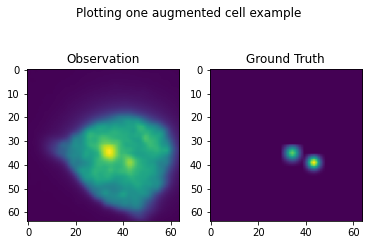

In [10]:
damaged_site_range = np.array([0, max_damage_sites + 1], dtype=int)
size_increase = 8
shrink_size = 64

data = LoadTIFF(TIFF_name, train_data_path)
shrinked_data = np.zeros([data.shape[0], shrink_size, shrink_size])
for i in range(data.shape[0]):
    shrinked_data[i, :, :] = ShrinkImages(data[i], shrink_size)
[augmented_data, ground_truth, GT_counts] = AugmentData(shrinked_data, damaged_site_range, size_increase)
for i in range(augmented_data.shape[0]):
    augmented_data[i] = augmented_data[i]
save_data(augmented_data, ground_truth)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(augmented_data, ground_truth, train_size=0.75)
[N1, H, W] = X_train.shape
[N2, H, W] = X_val.shape
X_train = torch.FloatTensor(X_train.reshape([N1, 1, H, W]))
y_train = torch.FloatTensor(y_train.reshape([N1, 1, H, W]))

X_val = torch.FloatTensor(X_val.reshape([N2, 1, H, W]))
y_val = torch.FloatTensor(y_val.reshape([N2, 1, H, W]))

plt.suptitle('Plotting one augmented cell example')
plt.subplot(121)
plt.imshow(X_train[0,0])
plt.title('Observation')
plt.subplot(122)
plt.imshow(y_train[0,0])
plt.title('Ground Truth')
plt.show()

### Train the model

You can change the name of the net at line 19. 
### CHANGE ?BETAS? ?EPOCHS? AND WHAT ELSE ?

In [13]:
# ======= Build Model =======
net = CNN_test().to(device)
lr = 1e-5
betas = (0.99, 0.999)
batch_size = 4
epochs = 250
early_stopping = 15
print_every = 1

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=betas)

# ========== Train ==========
dl_train = CreateDataLoader(X_train, y_train, batch_size=batch_size)
dl_val = CreateDataLoader(X_val, y_val, batch_size=batch_size)

trainer = Trainer(net, criterion, optimizer, device)
trainer.fit(dl_train, dl_val, num_epochs=epochs, early_stopping=early_stopping, print_every=print_every)
torch.save(trainer.model.state_dict(), 'CNN_model')

--- EPOCH 1/250 ---


KeyboardInterrupt: 

### The neural net will appear WHERE ? (be saved where)